In [1]:
%cd /home/assaf/jupyter/chess
%reset -f

import chess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from chess_utils import matrix_to_board

import torch.nn as nn



/home/assaf/jupyter/chess


### Build a DataSet

In [123]:


class ChessDataset(Dataset):
    def __init__(self, filename):
        with open(filename, "rb") as f:
            self.states_df = pickle.load(f)

    def __len__(self):
        return len(self.states_df)

    def __getitem__(self, idx):
        # display(self.states_df.iloc[idx])
        if self.states_df.iloc[idx].winner == 'black':
            winner = -1 
        elif self.states_df.iloc[idx].winner == 'white':
            winner = 1 
        else:
            winner = 0
        if self.states_df.iloc[idx].turn %2:   #white turn 
            brd_state =  self.states_df.iloc[idx].matrix
        else:
            brd_state =  np.flipud(-self.states_df.iloc[idx].matrix).copy() 
            winner = -winner
        n = torch.tensor(brd_state+7).unsqueeze(0).to(torch.int64)
        brd_state3d = torch.zeros(15, 8, 8, dtype=torch.float32)
        brd_state3d.scatter_(0, n, 1.0)
        brd_state3d = brd_state3d[[0,1,2,3,4,5,6,8,9,10,11,12,13,14],:,:]
        steps = self.states_df.iloc[idx].turns-self.states_df.iloc[idx].turn 
        result = torch.tensor((winner, steps), dtype=torch.float32)
        return brd_state3d, result
        # return torch.tensor(brd_state3d, dtype=torch.float32).unsqueeze(0), result

train_ds = ChessDataset("train_states_ds.pkl")
test_ds = ChessDataset("test_states_ds.pkl")
len(train_ds), len(test_ds)

# train_ds[1][0]

(657549, 78293)

In [ ]:
class MyChessNet(nn.Module):
    def __init__(self):
        super(MyChessNet, self).__init__()
        
        do = 0.0

        self.cnn_0 = nn.Conv2d(in_channels=14,  out_channels=64,  kernel_size=1, padding=0, stride=1) 

        self.fc_1 = nn.Linear(64*8*8,  4096)
        self.fc_2 = nn.Linear(4096,    4096)
        self.fc_3 = nn.Linear(4096,    4096) 
        self.fc_4 = nn.Linear(4096,    2048)
        self.fc_5 = nn.Linear(2048,    2048) #here comes pooling 4->2
        self.fc_6 = nn.Linear(2048,    1024)
        self.fc_7 = nn.Linear(1024,    512) #here comes pooling 2->1

        self.ln2d_1 = nn.LayerNorm([4096])
        self.ln2d_2 = nn.LayerNorm([4096])
        self.ln2d_3 = nn.LayerNorm([4096])
        self.ln2d_4 = nn.LayerNorm([2048])
        self.ln2d_5 = nn.LayerNorm([2048])
        self.ln2d_6 = nn.LayerNorm([1024])
        self.ln2d_7 = nn.LayerNorm([512])

        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.output_layer = nn.Linear(512, 3)
        self.dropout = nn.Dropout(p=do)

    def forward(self, x):
        x = self.cnn_0(x)

        x = torch.flatten(x,1)

        x = torch.relu(self.fc_1(x))
        # x = self.ln2d_1(x)
        x = self.dropout(x)

        x = torch.relu(self.fc_2(x))
        # x = self.ln2d_2(x)
        x = self.dropout(x)

        # x = torch.relu(self.fc_3(x))
        # x = self.ln2d_3(x)
        # x = self.dropout(x)

        x = torch.relu(self.fc_4(x))
        # x = self.ln2d_4(x)
        x = self.dropout(x)

        # x = torch.relu(self.fc_5(x))
        # x = self.ln2d_5(x)
        # x = self.dropout(x)

        x = torch.relu(self.fc_6(x))
        # x = self.ln2d_6(x)
        x = self.dropout(x)

        x = torch.relu(self.fc_7(x))
        # x = self.ln2d_7(x)
        x = self.dropout(x)

        x = self.output_layer(x)
        # print(x.shape)

        return x

In [276]:
class MyChessNet_hist(nn.Module):
    def __init__(self):
        super(MyChessNet_hist, self).__init__()
                
        self.net = nn.Sequential(
            nn.Linear(14, 14),
            nn.ReLU(),
            nn.Linear(14, 14),
            nn.ReLU(),
            nn.Linear(14, 14),
            nn.ReLU(),
            nn.Linear(14, 14),
            nn.ReLU(),
            nn.Linear(14, 14),
            nn.ReLU(),
            nn.Linear(14, 3)  # output logits
        )

    def forward(self, x):
        x = torch.sum(x,axis=(2,3))
        # print(x)

        return self.net(x)

In [282]:
class MyChessNet_simple(nn.Module):
    def __init__(self, sharpness=10.0):
        super(MyChessNet_simple, self).__init__()
        self.vars = nn.Parameter(torch.tensor([0.0, 1.0]))  # v0, v1
        self.k = sharpness
        tmpvec = torch.tensor([0.,0,-9, -5, -3, -3, -1, 1, 3, 3, 5, 9, 0 , 0]).T
        self.register_buffer("vec", tmpvec)

    def forward(self, x):
        x = torch.sum(x,axis=(2,3))
        x = x@self.vec 
        
        v0, v1 = self.vars
        s0 = torch.sigmoid(self.k * (x - v0))   # ~1 if x > v0
        s1 = torch.sigmoid(self.k * (x - v1))   # ~1 if x > v1

        out1 = 1 - s0               # x < v0
        out2 = s0 * (1 - s1)        # v0 < x < v1
        out3 = s1                   # x > v1

        return torch.stack([out1, out2, out3], dim=-1)

In [299]:
class MyChessNet_trnsfrm(nn.Module):
    def __init__(self, d_model=128, nhead=8, num_layers=4):
        super().__init__()

        # embed 14 → 64 per spatial location
        self.embed = nn.Linear(14, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128,
            nhead=8,
            dim_feedforward=512,   # ← this is dim_ff
            dropout=0.1,
            batch_first=True,
            activation="gelu"
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        self.cls = nn.Linear(d_model, 3)  # logits

    def forward(self, x):
        # x: (B, 14, 8, 8)
        B = x.size(0)

        x = x.permute(0, 2, 3, 1)      # (B, 8, 8, 14)
        x = x.reshape(B, 64, 14)       # (B, 64 tokens, 14)

        x = self.embed(x)              # (B, 64, 64)
        x = self.encoder(x)            # (B, 64, 64)

        x = x.mean(dim=1)              # global pooling
        return self.cls(x)             # (B, 3) logits

In [ ]:
class MyChessNet_trnsfrm2(nn.Module):
    def __init__(self, d_model=64, nhead=8, num_layers=4):
        super().__init__()

        self.embed = nn.Linear(14, d_model)

        # 2D positional embedding: 8x8 = 64 tokens
        self.pos_embed = nn.Parameter(torch.randn(64, d_model))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True
        )
        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        self.cls = nn.Linear(d_model, 3)

    def forward(self, x):
        # x: (B, 14, 8, 8)
        B = x.size(0)

        x = x.permute(0, 2, 3, 1)   # (B, 8, 8, 14)
        x = x.reshape(B, 64, 14)    # (B, 64, 14)

        x = self.embed(x)           # (B, 64, d_model)
        x = x + self.pos_embed      # add positional info

        x = self.encoder(x)         # (B, 64, d_model)
        x = x.mean(dim=1)           # global average pooling

        return self.cls(x)          # (B, 3) logits

In [302]:
import math

def sinusoidal_2d_positional_encoding(h, w, d_model, device):
    assert d_model % 4 == 0, "d_model must be divisible by 4"

    pe = torch.zeros(h, w, d_model, device=device)

    d_half = d_model // 2
    div_term = torch.exp(
        torch.arange(0, d_half, 2, device=device)
        * (-math.log(10000.0) / d_half)
    )

    pos_w = torch.arange(w, device=device).unsqueeze(1)
    pos_h = torch.arange(h, device=device).unsqueeze(1)

    # width (x)
    pe[:, :, 0:d_half:2] = torch.sin(pos_w * div_term)
    pe[:, :, 1:d_half:2] = torch.cos(pos_w * div_term)

    # height (y)
    pe[:, :, d_half::2] = torch.sin(pos_h * div_term)
    pe[:, :, d_half+1::2] = torch.cos(pos_h * div_term)

    return pe.view(h * w, d_model)

class HeavyTransformerClassifier(nn.Module):
    def __init__(self):
        super().__init__()

        # HEAVY hyperparameters
        d_model = 128
        nhead = 8
        num_layers = 6
        dim_feedforward = 512
        dropout = 0.1

        # embed per spatial token (14 → 128)
        self.embed = nn.Linear(14, d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            activation="gelu",
            batch_first=True
        )

        self.encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )

        self.head = nn.Linear(d_model, 3)  # logits

    def forward(self, x):
        # x: (B, 14, 8, 8)
        B, _, H, W = x.shape
        device = x.device

        # tokens
        x = x.permute(0, 2, 3, 1).reshape(B, H * W, 14)

        # embedding
        x = self.embed(x)  # (B, 64, 128)

        # positional encoding
        pos = sinusoidal_2d_positional_encoding(H, W, x.size(-1), device)
        x = x + pos.unsqueeze(0)

        # transformer
        x = self.encoder(x)

        # global pooling
        x = x.mean(dim=1)

        return self.head(x)  # (B, 3) logits


In [304]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
# device = 'cpu'
lr = 1e-3
weight_decay = 1e-3
batch_size = 128
epochs = 20

model = HeavyTransformerClassifier().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)

train_dataloader = DataLoader(train_ds, batch_size=batch_size, num_workers=8, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, num_workers=8, shuffle=False)

def criterion(output, targets):
    # msel = nn.MSELoss()
    # loss = msel(torch.tanh(output[:,0]),targets[:,0]) , msel(output[:,1],targets[:,1])

    loss = torch.nn.CrossEntropyLoss()
    return loss(output, targets+1)
    

def predict(y,target, tau=0.33):
    z=y*0
    z[y>tau] = 1
    z[y<-tau] = -1
    return torch.isclose(z,target, atol=1e-4, rtol=1e-4)

mloss = []
for epoch in range(epochs):
    if epoch == epochs//2:
        optimizer.param_groups[0]['lr'] /= 10

    model.train()
    p = 0
    acc_sum = 0
    loss_sum=np.array(0.)
    for features, targets in train_dataloader:
        features = features.to(device)
        targets = targets.to(device)
        output = model(features)
        # print(output.shape, targets[:,0])
        loss = criterion(output, torch.round(targets[:,0]).long())


        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  

        loss_sum += np.array(loss.item())
        acc_sum += (torch.round(torch.argmax(output,axis=1)-1) == targets[:,0]).sum().item()
        p += 1
    print(epoch, loss_sum/p, acc_sum/len(train_ds))
    mloss.append(loss_sum/p)


    model.eval()
    p = 0
    acc_sum = 0
    loss_sum=np.array(0.)
    with torch.no_grad():
        for features, targets in test_dataloader:
            features = features.to(device)
            targets = targets.to(device)
            output = model(features)
            loss = criterion(output, torch.round(targets[:,0]).long())

            loss_sum += np.array(loss.item())
            acc_sum += (torch.round(torch.argmax(output,axis=1)-1) == targets[:,0]).sum().item()
            p += 1
    print('test-results', epoch, loss_sum/p, acc_sum/len(test_ds))


Using device: cuda:0
0 0.7579961281636662 0.6292109029136992
test-results 0 0.7538470182251307 0.6603400048535629
1 0.7086585849210324 0.6731908952792872
test-results 1 0.7523209011194363 0.6649253445391031
2 0.6988683752498074 0.678533462905426
test-results 2 0.751148234565858 0.6610680392883144
3 0.6886019934042737 0.6842258143499572
test-results 3 0.7614511388408787 0.6544263216379498
4 0.6759929494281927 0.6901782224594669
test-results 4 0.7732147733053936 0.6609019963470553
5 0.6618553214195685 0.6972103980083614
test-results 5 0.7854782065096634 0.6509394198715083
6 0.6450725291062069 0.7053755689690046
test-results 6 0.7972797505752324 0.649049084847943
7 0.6260633102856336 0.7140030628896098
test-results 7 0.8187641157628665 0.6501347502330987
8 0.6057338017510644 0.7232449596912169
test-results 8 0.8575031243240326 0.646098629507108
9 0.5843672625468185 0.7341871100100524
test-results 9 0.8869828542974455 0.6368513149323695
10 0.5210591492635724 0.7642730807894165
test-results

KeyboardInterrupt: 

In [308]:
!ls -l data

total 21812
-rw-r--r-- 1 assaf users 1133048 Jan  8 14:52 20260108-101653-815964_t01.pkl
-rw-r--r-- 1 assaf users 1110016 Jan  8 14:46 20260108-101653-819148_t01.pkl
-rw-r--r-- 1 assaf users 1129069 Jan  8 14:51 20260108-101653-821583_t01.pkl
-rw-r--r-- 1 assaf users 1094313 Jan  8 14:43 20260108-101653-822167_t01.pkl
-rw-r--r-- 1 assaf users 1111129 Jan  8 14:47 20260108-101653-822254_t01.pkl
-rw-r--r-- 1 assaf users 1114818 Jan  8 14:47 20260108-101653-824128_t01.pkl
-rw-r--r-- 1 assaf users 1110645 Jan  8 14:47 20260108-101653-825998_t01.pkl
-rw-r--r-- 1 assaf users 1109335 Jan  8 14:46 20260108-101653-828330_t01.pkl
-rw-r--r-- 1 assaf users 1110834 Jan  8 14:47 20260108-101653-840746_t01.pkl
-rw-r--r-- 1 assaf users 1110055 Jan  8 14:47 20260108-101653-856527_t01.pkl
-rw-r--r-- 1 assaf users 1111269 Jan  8 19:14 20260108-144314-365994_t01.pkl
-rw-r--r-- 1 assaf users 1096454 Jan  8 19:14 20260108-144641-542030_t01.pkl
-rw-r--r-- 1 assaf users 1136344 Jan  8 19:23 20260108-144645-04

In [13]:
(matrix_to_board(train_ds[76][0]))

n  = (train_ds[76][0])
print(n.shape)
n = torch.round(train_ds[76][0]+7).to(torch.int64)
out = torch.zeros(14, 8, 8, dtype=torch.float32)
out.scatter_(0, n, 1.0)

out

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [14]:
import torch.nn as nn 
import torch
pool = nn.MaxPool2d(kernel_size=2, stride=2)

a = torch.arange(8).unsqueeze(1)
b = torch.arange(8).unsqueeze(1)/10
x = a.T+b
x = x.unsqueeze(0)
y = pool(x)
print(x,y)

tensor([[[0.0000, 1.0000, 2.0000, 3.0000, 4.0000, 5.0000, 6.0000, 7.0000],
         [0.1000, 1.1000, 2.1000, 3.1000, 4.1000, 5.1000, 6.1000, 7.1000],
         [0.2000, 1.2000, 2.2000, 3.2000, 4.2000, 5.2000, 6.2000, 7.2000],
         [0.3000, 1.3000, 2.3000, 3.3000, 4.3000, 5.3000, 6.3000, 7.3000],
         [0.4000, 1.4000, 2.4000, 3.4000, 4.4000, 5.4000, 6.4000, 7.4000],
         [0.5000, 1.5000, 2.5000, 3.5000, 4.5000, 5.5000, 6.5000, 7.5000],
         [0.6000, 1.6000, 2.6000, 3.6000, 4.6000, 5.6000, 6.6000, 7.6000],
         [0.7000, 1.7000, 2.7000, 3.7000, 4.7000, 5.7000, 6.7000, 7.7000]]]) tensor([[[1.1000, 3.1000, 5.1000, 7.1000],
         [1.3000, 3.3000, 5.3000, 7.3000],
         [1.5000, 3.5000, 5.5000, 7.5000],
         [1.7000, 3.7000, 5.7000, 7.7000]]])


In [ ]:
model = MyChessNet()
inp = train_ds[76][0]
# display(inp.shape)
inp = torch.stack([inp])
# inp = torch.cat([inp, inp])
# display(inp.shape)
# display(inp)
output = model(inp)
output , train_ds[76][1]

a=np.array((1,2,3))
a+(1,22,3)

import os
os.cpu_count()

20

In [16]:
def predict(y,target, tau=0.33):
    z=y*0
    z[y>tau] = 1
    z[y<-tau] = -1
    return z
x=torch.arange(-1,1,0.1)

torch.stack([x,predict(x,x)]).T
torch.isclose(predict(x,x) ,x*0)

tensor([False, False, False, False, False, False, False,  True,  True,  True,
         True,  True,  True,  True, False, False, False, False, False, False])

In [147]:
def get_np_board(board_):
    matrix = np.zeros((8, 8), dtype=np.int8)
    piece_values = {
        chess.PAWN: 1,
        chess.KNIGHT: 2,
        chess.BISHOP: 3,
        chess.ROOK: 4,
        chess.QUEEN: 5,
        chess.KING: 6,
    }
    for square, piece in board_.piece_map().items():
        row = 7 - chess.square_rank(square)
        col = chess.square_file(square)
        value = piece_values[piece.piece_type]
        matrix[row, col] = value if piece.color == chess.WHITE else -value    
    return matrix

def get_torch_board(npboard, flip=False):
    if flip:
        npboard = np.flipud(-npboard).copy()
    n = torch.tensor(npboard+7).unsqueeze(0).to(torch.int64)
    brd_state3d = torch.zeros(15, 8, 8, dtype=torch.float32)
    brd_state3d.scatter_(0, n, 1.0)
    brd_state3d = brd_state3d[[0,1,2,3,4,5,6,8,9,10,11,12,13,14],:,:]
    return brd_state3d

In [272]:
model = MyChessNet_hist()
model(i).shape

tensor([[0., 1., 0., 2., 0., 1., 8., 6., 2., 3., 2., 1., 1., 0.],
        [0., 1., 0., 2., 0., 1., 8., 6., 2., 3., 2., 1., 1., 0.]])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (2x14 and 4096x4096)

In [267]:
i = get_torch_board(get_np_board(board))
i.shape
i=torch.stack((i,i))
i.shape
s = torch.sum(i,axis=(2,3))
score_black = s @ torch.tensor([0.,0,9, 5, 3, 3, 1, 0, 0, 0, 0, 0, 0 , 0]).T
score_white = s @ torch.tensor([0.,0, 0, 0, 0, 0, 0, 1, 3, 3, 5, 9, 0 , 0]).T
s, score_black, score_white


(tensor([[0., 1., 0., 2., 0., 1., 8., 6., 2., 3., 2., 1., 1., 0.],
         [0., 1., 0., 2., 0., 1., 8., 6., 2., 3., 2., 1., 1., 0.]]),
 tensor([21., 21.]),
 tensor([40., 40.]))

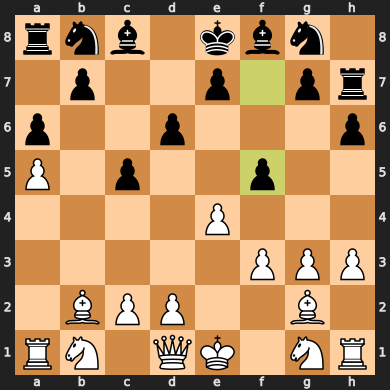

In [259]:
move = random.choice(list(board.legal_moves))
board.push(move)
board

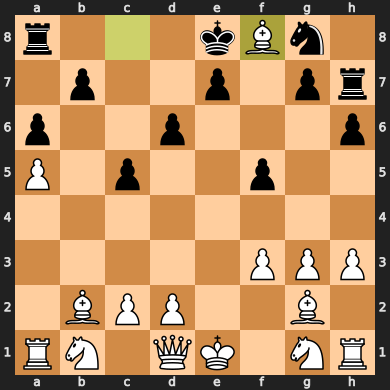

In [263]:
board.push(chess.Move.from_uci('c8f8'))
board

In [176]:
import chess

result_str = {
    "1-0": 'White',
    "0-1": 'Black',
    "1/2-1/2": 'Draw'
}
result_val = {
    "1-0": 1,
    "0-1": -1,
    "1/2-1/2": 0
}


board = chess.Board()

def get_model_move(model, board):
    mdevice = next(model.parameters()).device
    moves = list(board.legal_moves)
    scores = [] 
    # print(moves[0].uci())
    for move in moves:
        board.push(move)
        if board.is_checkmate():
            scores.append((move, 2))
        else:
            model.eval()
            with torch.no_grad():
                npbrd = get_np_board(board)
                tbrd = get_torch_board(npbrd).unsqueeze(0).to(mdevice)
                y = model(tbrd)
                # print(y,nn.functional.softmax(y.squeeze(),dim=0),nn.functional.softmax(y.squeeze(),dim=0)[0].item())
                scores.append((move, (nn.functional.softmax(y.squeeze(),dim=0)[0]).item()))
        board.pop()
    scores.sort(key=lambda x: x[1], reverse=True)
    # print(scores)
    return scores

moves = get_model_move(model, board)

print(moves[0])

# npbrd, tbrd
# tbrd.shape

(Move.from_uci('d2d3'), 0.6163426041603088)


In [177]:
import chess.engine

board = chess.Board()

engine = chess.engine.SimpleEngine.popen_uci("./stockfish")

result = engine.play(
    board,
    chess.engine.Limit(time=1)  # think time
)

print("Suggested move:", result.move)
print("UCI:", result.move.uci())
print("SAN:", board.san(result.move))

engine.quit()

Suggested move: e2e4
UCI: e2e4
SAN: e4


In [305]:
sumi=0
for j in range(10):
    engine = chess.engine.SimpleEngine.popen_uci("./stockfish")

    # engine.configure({
    #     "UCI_LimitStrength": True,
    #     "UCI_Elo": 1320
    # })

    engine.configure({
        "Skill Level": 0 #0-20
    })
    
    board = chess.Board()
    i=0
    while not board.is_game_over():
        mmove = get_model_move(model, board)[0][0]
        board.push(mmove)
        # display(board)
        i+=1

        if board.is_game_over():
            break
        fishout = engine.play(board, chess.engine.Limit(depth=1))
        # fishout = engine.play(board, chess.engine.Limit(time=0.001))
        board.push(fishout.move)
       
        # display(board)
        i+=1

    engine.quit()

    result = board.result()
    print (result_str[result], i)
    sumi+=i*result_val[result]



Black 102
Black 44
Black 64
Black 98
Black 38
Black 30
Black 64
Black 36
Black 58
Black 66


In [121]:
import chess 
from datetime import datetime
import random 
import pickle

if random.randint(0,4) == 0:
    speed = 'slow'
    T = 1
else:
    speed = 'fast'
    T=0.1

timestamp = datetime.now().strftime("%Y%m%d-%H%M%S-%f")
name = timestamp+'_'+speed
print (name)
moves = []
for j in range(1):
    engine1 = chess.engine.SimpleEngine.popen_uci("./stockfish")
    engine2 = chess.engine.SimpleEngine.popen_uci("./stockfish")

    # engine1.configure({
    #     "UCI_LimitStrength": True,
    #     "UCI_Elo": 1320
    # })
    engine1.configure({
        "Skill Level": 20 #0-20
    })
    
    engine2.configure({
        "Skill Level": 20 #0-20
    })
    
    board = chess.Board()
    i=0
    while not board.is_game_over():

        fishout = engine1.play(board, chess.engine.Limit(time=T))
        board.push(fishout.move)
        i+=1

        if board.is_game_over():
            break
        fishout = engine2.play(board, chess.engine.Limit(time=T))
        board.push(fishout.move)
       
        # display(board)
        i+=1

    engine1.quit()
    engine2.quit()

    result = board.result()
    print (j, result_str[result], i)
    moves.append([[m.uci() for m in board.move_stack], board.result()])
  

with open(name+ ".pkl", "wb") as f:
    pickle.dump(moves, f)



20260107-204213-774610_fast
0 Draw 150


In [122]:

print()
print(datetime.now().strftime("%Y%m%d_%H%M%S%f"))
print(datetime.now().strftime("%Y%m%d_%H%M%S%f"))
!ls




20260107_204316306617
20260107_204316306784
20260107-204213-774610_fast.pkl  stockfish
all_states_ds.pkl		 stockfish_
chess_database.ipynb		 stockfish-ubuntu-x86-64-avx2.tar
chess_utils.py			 test_states_ds.pkl
data				 train.py
games.csv			 train_states_ds.pkl
__pycache__


In [199]:
filename = 'data/20260108-101653-815964_t01.pkl'

with open(filename, "rb") as f:
    dat = pickle.load(f)

sum = 0 
for i in range(len(dat)):
    if (dat[i][1]=='1-0'):
        sum +=1
sum
counter(sum)

NameError: name 'counter' is not defined